## Import Stuff

In [1]:
%matplotlib inline
from importlib import reload
import utils; reload(utils)
from utils import *

Using cuDNN version 5105 on context None
Preallocating 3276/4095 Mb (0.800000) on cuda0


Mapped name None to device cuda0: GeForce GTX 650 (0000:01:00.0)
Using TensorFlow backend.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import dicom
import scipy.misc

import SimpleITK as sitk
import time
from os import listdir, walk

## Load images and get spacing for images

In [293]:
'''
This function reads a '.mhd' file using SimpleITK and return the image array, 
origin and spacing of the image.
'''
def load_itk(filename):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(filename)
    
    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    ct_scan = sitk.GetArrayFromImage(itkimage)
    
    # Read the origin of the ct_scan, will be used to convert the coordinates from world to voxel and vice versa.
    origin = np.array(list(reversed(itkimage.GetOrigin())))
    
    # Read the spacing along each dimension
    spacing = np.array(list(reversed(itkimage.GetSpacing())))
    
    return ct_scan, origin, spacing

'''
This function is used to convert the world coordinates to voxel coordinates using 
the origin and spacing of the ct_scan
'''
def world_2_voxel(world_coordinates, origin, spacing):
    stretched_voxel_coordinates = world_coordinates - origin # np.absolute(world_coordinates - origin)
    voxel_coordinates = stretched_voxel_coordinates / spacing
    return voxel_coordinates

'''
This function is used to convert the voxel coordinates to world coordinates using 
the origin and spacing of the ct_scan.
'''
def voxel_2_world(voxel_coordinates, origin, spacing):
    stretched_voxel_coordinates = voxel_coordinates * spacing
    world_coordinates = stretched_voxel_coordinates + origin
    return world_coordinates

def load_itk_spacing(filename):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(filename)
    
      
    # Read the spacing along each dimension
    spacing = np.array(list(reversed(itkimage.GetSpacing())))
    
    return spacing

def normalizePlanes(npzarray):
    maxHU = 400.
    minHU = -1000.
    npzarray = (npzarray - minHU) / (maxHU - minHU)
    npzarray[npzarray>1] = 1.
    npzarray[npzarray<0] = 0.
    return npzarray

import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

In [4]:
def seq(start, stop, step=1):
    n = int(round((stop - start)/float(step)))
    if n > 1:
        return([start + step*i for i in range(n+1)])
    else:
        return([])

'''
This function is used to create spherical regions in binary masks
at the given locations and radius.
'''
def draw_circles(image,cands,origin,spacing):
    RESIZE_SPACING = [1, 1, 1]
    image_mask = np.zeros(image.shape)
    
    for ca in cands.values:
        #get middel x-,y-, and z-worldcoordinate of the nodule
        radius = np.ceil(ca[4])/2
        coord_x = ca[1]
        coord_y = ca[2]
        coord_z = ca[3]
        image_coord = np.array((coord_z,coord_y,coord_x))

        #determine voxel coordinate given the worldcoordinate
        image_coord = world_2_voxel(image_coord,origin,spacing)
        
        #determine the range of the nodule
        noduleRange = seq(-radius, radius, RESIZE_SPACING[0])
        
        #create the mask
        for x in noduleRange:
            for y in noduleRange:
                for z in noduleRange:
                    coords = world_2_voxel(np.array((coord_z+z,coord_y+y,coord_x+x)),origin,spacing)
                    if (np.linalg.norm(image_coord-coords) * RESIZE_SPACING[0]) < radius:
                        image_mask[np.round(coords[0]),np.round(coords[1]),np.round(coords[2])] = int(1)
    return image_mask

'''
This function takes the path to a '.mhd' file as input and 
is used to create the nodule masks and segmented lungs after 
rescaling to 1mm size in all directions. It saved them in the .npz
format. It also takes the list of nodule locations in that CT Scan as 
input.
'''
def create_nodule_mask(imagePath, maskPath, cands):
    #if os.path.isfile(imagePath.replace('original',SAVE_FOLDER_image)) == False:
    img, origin, spacing = load_itk(imagePath)

    #calculate resize factor
    RESIZE_SPACING = [1, 1, 1]
    resize_factor = spacing / RESIZE_SPACING
    new_real_shape = img.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize = new_shape / img.shape
    new_spacing = spacing / real_resize
    
    #resize image
    lung_img = scipy.ndimage.interpolation.zoom(img, real_resize)
    
    # Segment the lung structure
    lung_img = lung_img + 1024
    lung_mask = segment_lung_from_ct_scan(lung_img)
    lung_img = lung_img - 1024

    #create nodule mask
    nodule_mask = draw_circles(lung_img,cands,origin,new_spacing)

    lung_img_512, lung_mask_512, nodule_mask_512 = np.zeros((lung_img.shape[0], 512, 512)), np.zeros((lung_mask.shape[0], 512, 512)), np.zeros((nodule_mask.shape[0], 512, 512))

    original_shape = lung_img.shape	
    for z in range(lung_img.shape[0]):
        offset = (512 - original_shape[1])
        upper_offset = np.round(offset/2)
        lower_offset = offset - upper_offset

        new_origin = voxel_2_world([-upper_offset,-lower_offset,0],origin,new_spacing)

        lung_img_512[z, upper_offset:-lower_offset,upper_offset:-lower_offset] = lung_img[z,:,:]
        lung_mask_512[z, upper_offset:-lower_offset,upper_offset:-lower_offset] = lung_mask[z,:,:]
        nodule_mask_512[z, upper_offset:-lower_offset,upper_offset:-lower_offset] = nodule_mask[z,:,:]

    # save images.    
    np.save(imageName + '_lung_img.npz', lung_img_512)
    np.save(imageName + '_lung_mask.npz', lung_mask_512)
    np.save(imageName + '_nodule_mask.npz', nodule_mask_512)
        

In [56]:
data_path = "/Volumes/Backups/data/LUNA16/"

In [110]:
patient_slice = load_itk(data_path + "subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987.mhd")

In [13]:
annotations = pd.read_csv(data_path + "annotations.csv")

In [15]:
candidates = pd.read_csv(data_path + "candidates3.csv")

In [275]:
candidates[4:5]

,seriesuid,coordX,coordY,coordZ,class
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886,75.721224,92.887331,-119.270564,1


In [18]:
annotations


,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150
5,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,90.931713,149.027266,-426.544715,18.208570
6,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,89.540769,196.405159,-515.073322,16.381276
7,1.3.6.1.4.1.14519.5.2.1.6279.6001.100953483028...,81.509646,54.957219,-150.346423,10.362321
8,1.3.6.1.4.1.14519.5.2.1.6279.6001.102681962408...,105.055792,19.825260,-91.247251,21.089619
9,1.3.6.1.4.1.14519.5.2.1.6279.6001.104562737760...,-124.834262,127.247155,-473.064479,10.465854


In [19]:
patient_slice



(array([[[-2048, -2048, -2048, ..., -2048, -2048, -2048],
         [-2048, -2048, -2048, ..., -2048, -2048, -2048],
         [-2048, -2048, -2048, ..., -2048, -2048, -2048],
         ..., 
         [-2048, -2048, -2048, ..., -2048, -2048, -2048],
         [-2048, -2048, -2048, ..., -2048, -2048, -2048],
         [-2048, -2048, -2048, ..., -2048, -2048, -2048]],
 
        [[-2048, -2048, -2048, ..., -2048, -2048, -2048],
         [-2048, -2048, -2048, ..., -2048, -2048, -2048],
         [-2048, -2048, -2048, ..., -2048, -2048, -2048],
         ..., 
         [-2048, -2048, -2048, ..., -2048, -2048, -2048],
         [-2048, -2048, -2048, ..., -2048, -2048, -2048],
         [-2048, -2048, -2048, ..., -2048, -2048, -2048]],
 
        [[-2048, -2048, -2048, ..., -2048, -2048, -2048],
         [-2048, -2048, -2048, ..., -2048, -2048, -2048],
         [-2048, -2048, -2048, ..., -2048, -2048, -2048],
         ..., 
         [-2048, -2048, -2048, ..., -2048, -2048, -2048],
         [-2048, -204

In [20]:
patient_slice[0][0][0]


array([-2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048,
       -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048,
       -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048,
       -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048,
       -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048,
       -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048,
       -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048,
       -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048,
       -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048,
       -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048, -2048,
       -2048, -2048,

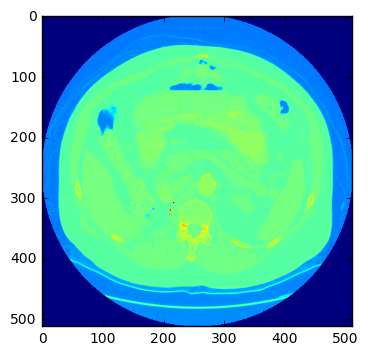

In [21]:
plt.imshow(patient_slice[0][0])


In [22]:
plt.show()


In [23]:
patient_slice[0][0][300]

array([-2048, -2048, -2048, -2048,  -972,  -971,  -975,  -981,  -984,  -983,  -976,  -965,  -943,
        -937,  -965,  -981,  -991, -1012, -1004,  -994,  -983,  -953,  -947,  -959,  -951,  -929,
        -838,  -563,  -174,    10,   -46,   -91,  -102,  -110,  -125,  -148,  -128,  -115,   -91,
         -82,   -84,   -98,  -123,  -126,  -140,  -149,  -148,  -122,   -95,   -72,   -77,   -55,
         -34,   -17,    10,    49,    53,    57,    45,    39,   158,   282,   330,   288,   221,
         135,    75,    50,   -38,   -71,   -22,    20,    62,    82,    62,    75,    97,   106,
         117,    68,    68,   103,    78,   112,    99,   105,    66,    79,    46,    28,    48,
          55,    67,    42,    36,    53,    59,    93,   107,    65,    52,    79,    94,    64,
          70,    80,    86,    97,    92,    93,    44,    60,    99,    77,    78,    64,    36,
          50,    88,    71,    63,    56,     9,    17,    15,   -42,   -61,   -75,   -92,   -96,
        -118,  -140,

In [24]:
patient_slice[2]

array([ 2.5   ,  0.8203,  0.8203])

In [25]:
type(image)

module

In [113]:
image = sitk.ReadImage(data_path + "subset0//1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd")

In [114]:
print (image.GetSize())

(512, 512, 121)


In [30]:
print (image.GetOrigin())
print (image.GetSpacing())
print (image.GetDirection())

print (image.GetNumberOfComponentsPerPixel())

(-212.199997, -210.0, -338.0)
(0.8203120231628418, 0.8203120231628418, 2.5)
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
1


In [31]:
slice_array=slice_array.transpose(0,2,3,1)

NameError: name 'slice_array' is not defined

In [ ]:
slice_array.shape

In [32]:
sitk.GetArrayFromImage(image)[0:3].shape

(3, 512, 512)

In [ ]:
sitk.GetArrayFromImage(image).shape

In [ ]:
plt.imshow(sitk.GetArrayFromImage(image)[99])

In [ ]:
image.GetSpacing()

In [ ]:
image_array=sitk.GetArrayFromImage(image)

In [ ]:
(image_array).shape


In [33]:
def get_5dslice(d_image,slice_loc):
    slice = sitk.GetArrayFromImage(d_image)[slice_loc-2:slice_loc+3]
    return slice


TypeError: Invalid dimensions for image data

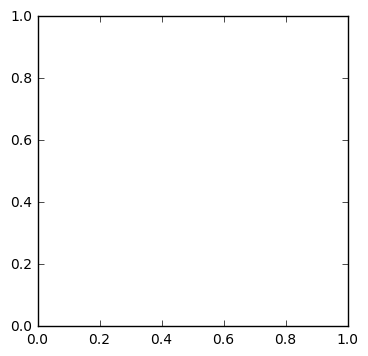

In [34]:
plt.imshow(get_5dslice(image,91))

In [35]:
new_image = get_5dslice(image,91)

In [36]:
a = np.array([0,1,2])

In [37]:
np.roll(a,1)

array([2, 0, 1])

In [38]:
def resample_image(image, image_array, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    
    real_spacing =  image.GetSpacing()
    spacing = np.array(np.roll(real_spacing,1), dtype=np.float32)

    resize_factor = spacing / new_spacing
    print(spacing)
    new_real_shape = image_array.shape * resize_factor
    new_shape = np.round(new_real_shape)
    print(new_shape)
    real_resize_factor = new_shape / image_array.shape
    new_spacing = spacing / real_resize_factor
    print(new_spacing)
    image_array2 = scipy.ndimage.interpolation.zoom(image_array, real_resize_factor, mode='nearest')
    
    return image_array2, new_spacing


In [39]:
%time outcome = resample_image(image,new_image)

[ 2.5     0.8203  0.8203]
[  12.  420.  420.]
[ 1.0417  1.      1.    ]
CPU times: user 1.25 s, sys: 10.6 ms, total: 1.26 s
Wall time: 1.27 s


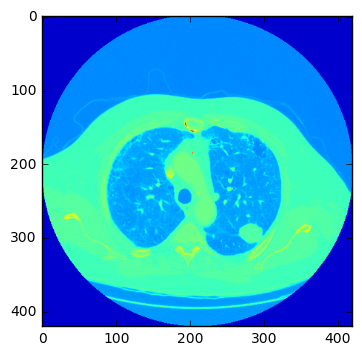

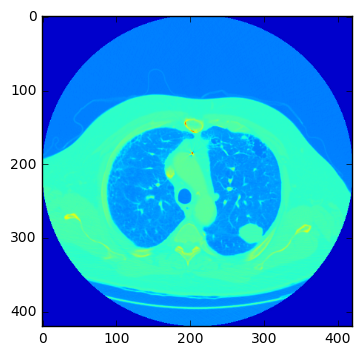

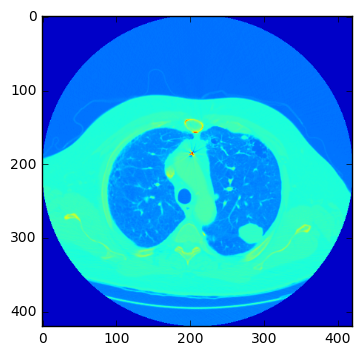

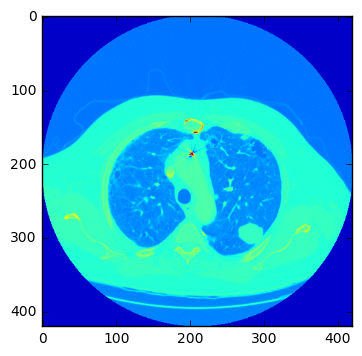

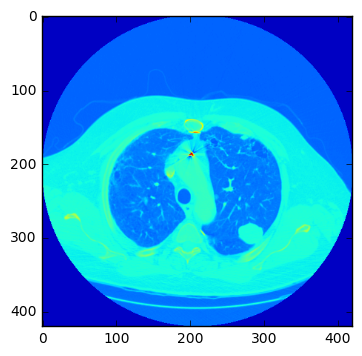

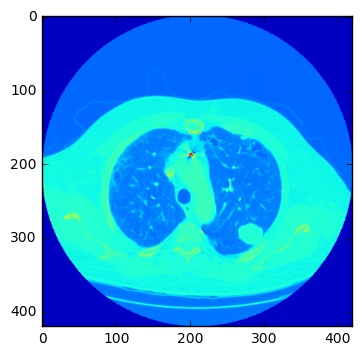

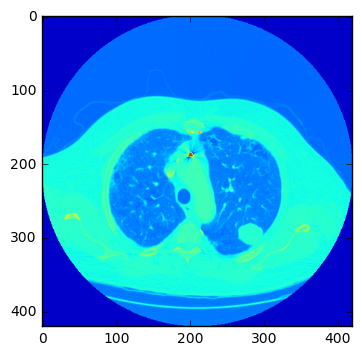

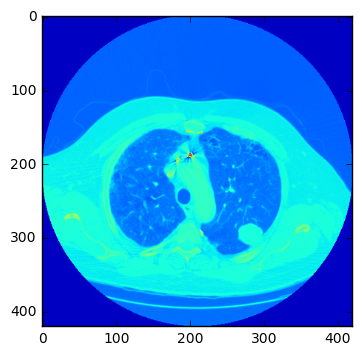

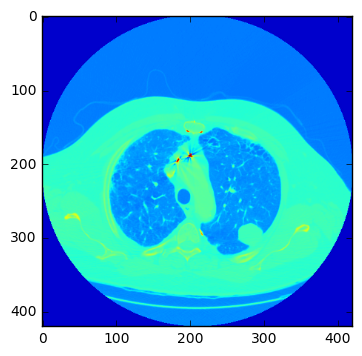

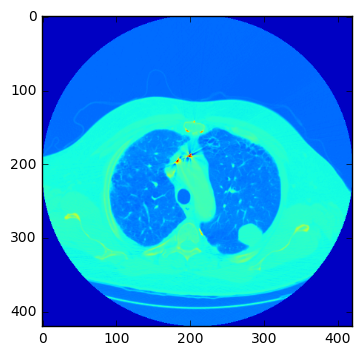

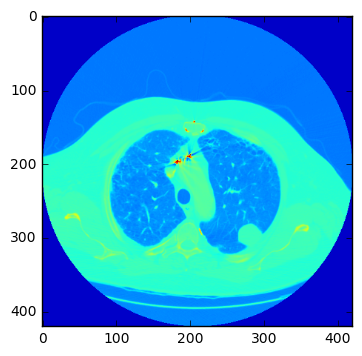

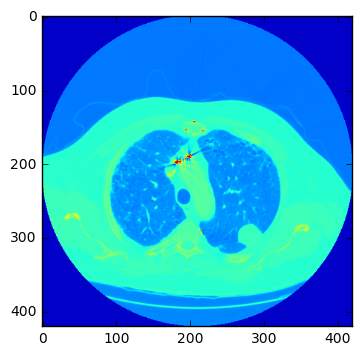

In [40]:
for i in range(12):
    plt.imshow(outcome[0][i])
    plt.show()

In [41]:
def get_3dslice(d_image,slice_loc):
    slice = sitk.GetArrayFromImage(d_image)[slice_loc-1:slice_loc+2]
    return slice

In [43]:
slice = sitk.GetArrayFromImage(image)[slice_loc-1:slice_loc+2]

NameError: name 'slice_loc' is not defined

In [44]:
get_3dslice(image,4).shape

(3, 512, 512)

In [45]:
def create_slice_array(image):
    num_layers = image.GetSize()[2]-2
    print(num_layers)
    slice_array = np.zeros((image.GetSize()[2]-2,3,512,512))
    for i in range(num_layers):
        slice =  np.zeros((3,512,512))
        slice_array[i] = get_3dslice(image,i+1)
    slice_array = slice_array.transpose(0,2,3,1)
    return slice_array

In [46]:
slice_array.shape


NameError: name 'slice_array' is not defined

In [47]:
%time color_array = create_slice_array(image)

121
CPU times: user 1.88 s, sys: 1.83 s, total: 3.72 s
Wall time: 3.74 s


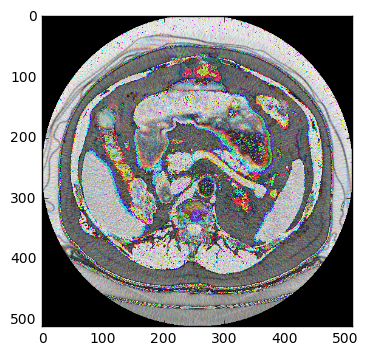

In [48]:
color_array[92].shape
plt.imshow(color_array[0])

In [49]:
for i in range(len(slice_array)):
    plt.imshow(slice_array[i])
    plt.show()

NameError: name 'slice_array' is not defined

In [50]:
candidates.values

array([['1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886', 64.1029275775,
        84.9841485639, -95.26109041459999, 1],
       ['1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886', 66.1283826307,
        91.4358740771, -121.999167539, 1],
       ['1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886', 58.106059702299994,
        81.3088980717, -97.8160367908, 1],
       ['1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886', 67.61451718,
        85.02525992, -109.8084416, 1],
       ['1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886', 75.7212243102,
        92.88733103940001, -119.27056405200001, 1],
       ['1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886', 57.3694276965,
        83.2399662237, -114.664766642, 1],
       ['1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886', 75.2239949525,
        79.4552680171, -121.43016833700001, 1],
       ['1.3.6.1.4.1.14519.5.2.1.6279.6001.28

In [51]:
annotations.loc[annotations['diameter_mm'].idxmax(),'coordZ']

-109.74672379999998

In [52]:
annotations

,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150
5,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,90.931713,149.027266,-426.544715,18.208570
6,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,89.540769,196.405159,-515.073322,16.381276
7,1.3.6.1.4.1.14519.5.2.1.6279.6001.100953483028...,81.509646,54.957219,-150.346423,10.362321
8,1.3.6.1.4.1.14519.5.2.1.6279.6001.102681962408...,105.055792,19.825260,-91.247251,21.089619
9,1.3.6.1.4.1.14519.5.2.1.6279.6001.104562737760...,-124.834262,127.247155,-473.064479,10.465854


In [53]:
annotations['diameter_mm'].max()

32.270030249999998

In [54]:
mhd_file = (data_path + '')

In [55]:
mhdfiles = []
spacing_list = []

for dirName, subdirList, fileList in os.walk(data_path):
    for subdirName in subdirList:
        if subdirName.startswith('sub'):
            print (subdirName)
            for dirName2,subdirList2,fileList2 in os.walk(dirName + subdirName):
                for file in fileList2:
                    if file.endswith('mhd'):
                        mhdfiles.append(dirName2 + '/' +file)
                        templist = (load_itk_spacing(dirName2 + '/' +file))
                        tempfilelist = [dirName2 + '/' + file, file]
                        for x in templist:
                            tempfilelist.append(x)
                        spacing_list.append(tempfilelist)

subset0
subset1
subset2
subset3
subset4
subset5
subset6
subset7
subset8
subset9


In [74]:
spacing_df = pd.DataFrame(spacing_list)

In [75]:
spacing_df.columns = ["file_loc","seriesuid",'dz','dx','dy']

In [79]:
spacing_df['seriesuid'].replace(regex=True,inplace=True,to_replace=r'.mhd',value=r'')


In [80]:
pd.options.display.max_colwidth = 100

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1563b5f28>]], dtype=object)

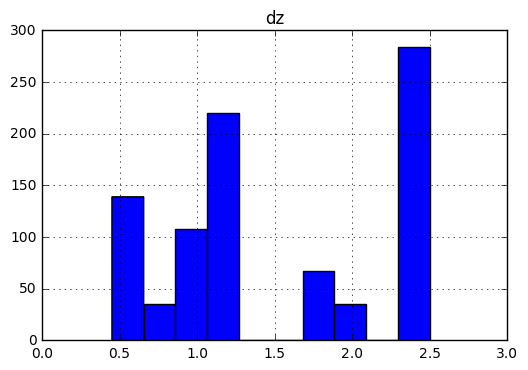

In [115]:
spacing_df.hist(column='dz')

In [85]:
candidates


,seriesuid,coordX,coordY,coordZ,class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886,64.102928,84.984149,-95.261090,1
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886,66.128383,91.435874,-121.999168,1
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886,58.106060,81.308898,-97.816037,1
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886,67.614517,85.025260,-109.808442,1
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886,75.721224,92.887331,-119.270564,1
5,1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886,57.369428,83.239966,-114.664767,1
6,1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886,75.223995,79.455268,-121.430168,1
7,1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886,113.840000,-11.560000,-164.490000,1
8,1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886,66.821473,81.892206,-121.793470,1
9,1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886,102.843497,67.076606,-238.600281,1


In [118]:
cand

'seriesuid'

In [117]:
type(candidates)

pandas.core.frame.DataFrame

In [99]:
# get candidates
for cand in candidates:
    worldCoord = np.asarray(candidates['coordZ']),candidates['coordY'],candidates['coordY'])
    voxelCoord = worldToVoxelCoord(worldCoord, numpyOrigin, numpySpacing)
    voxelWidth = 100
    patch = numpyImage[voxelCoord[0],voxelCoord[1]-voxelWidth/2:voxelCoord[1]+voxelWidth/2,voxelCoord[2]-voxelWidth/2:voxelCoord[2]+voxelWidth/2]
    patch = normalizePlanes(patch)
    print ('data')
    print (worldCoord)
    print (voxelCoord)
    print (patch)
    outputDir = 'patches/'
    plt.imshow(patch, cmap='gray')
    plt.show()
    Image.fromarray(patch*255).convert('L').save("/Volumes/Backups/data/LUNA16/" + outputDir + 'patch_' + str(worldCoord[0])  + '_' + str(worldCoord[1]) + '_' + str(worldCoord[2]) + '.tiff')


SyntaxError: invalid syntax (<ipython-input-99-e08ed7782691>, line 3)

In [125]:
annotations.head()

,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860,103.783651,-211.925149,-227.121250,4.224708
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208,69.639017,-140.944586,876.374496,5.786348
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405,-24.013824,192.102405,-391.081276,8.143262
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405,2.441547,172.464881,-405.493732,18.545150


In [126]:
candidates.head()

,seriesuid,coordX,coordY,coordZ,class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886,64.102928,84.984149,-95.261090,1
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886,66.128383,91.435874,-121.999168,1
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886,58.106060,81.308898,-97.816037,1
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886,67.614517,85.025260,-109.808442,1
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886,75.721224,92.887331,-119.270564,1


In [188]:
candidates_full = pd.read_csv(data_path + "candidates.csv")

In [197]:
candidates_tumor = candidates_full.loc[candidates_full['class'] == 1]

In [198]:
len (candidates_tumor)

1351

In [206]:
candidates_tumor.head()

,seriesuid,coordX,coordY,coordZ,class
13,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860,104.164804,-211.685591,-227.011364,1
78,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860,-128.940000,-175.040000,-297.870000,1
1303,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208,70.190000,-140.930000,877.680000,1
3050,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405,89.320000,190.840000,-516.820000,1
3052,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405,94.930000,153.030000,-429.910000,1


In [216]:
candidates_class1_df = pd.merge(spacing_df,candidates_tumor, on='seriesuid',how='outer').dropna()

In [279]:
candidates_class1_df[candidates_class1_df.seriesuid == '1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886']

,file_loc,seriesuid,dz,dx,dy,coordX,coordY,coordZ,class
255,/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.2879662446442806907370192...,1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886,2.5,0.820312,0.820312,64.102928,84.984149,-95.261090,1.0
256,/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.2879662446442806907370192...,1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886,2.5,0.820312,0.820312,66.128383,91.435874,-121.999168,1.0
257,/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.2879662446442806907370192...,1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886,2.5,0.820312,0.820312,58.106060,81.308898,-97.816037,1.0
258,/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.2879662446442806907370192...,1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886,2.5,0.820312,0.820312,67.614517,85.025260,-109.808442,1.0
259,/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.2879662446442806907370192...,1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886,2.5,0.820312,0.820312,75.721224,92.887331,-119.270564,1.0
260,/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.2879662446442806907370192...,1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886,2.5,0.820312,0.820312,57.369428,83.239966,-114.664767,1.0
261,/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.2879662446442806907370192...,1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886,2.5,0.820312,0.820312,75.223995,79.455268,-121.430168,1.0
262,/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.2879662446442806907370192...,1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886,2.5,0.820312,0.820312,113.840000,-11.560000,-164.490000,1.0
263,/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.2879662446442806907370192...,1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886,2.5,0.820312,0.820312,66.821473,81.892206,-121.793470,1.0
264,/Volumes/Backups/data/LUNA16/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.2879662446442806907370192...,1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886,2.5,0.820312,0.820312,102.843497,67.076606,-238.600281,1.0


In [ ]:
# get candidates
for   index,row in candidates_class1_df.iterrows():
    numpyImage, numpyOrigin, numpySpacing = load_itk(row[0])
    print (numpyImage.shape)
    print (numpyOrigin.shape)
    print (numpyOrigin)
    
    print (numpySpacing)
    worldCoord =([row[7],row[6],row[5]])
    voxelCoord = world_2_voxel(worldCoord, numpyOrigin, numpySpacing)
    voxelWidth = 224
    patch = numpyImage[voxelCoord[0],voxelCoord[1]-voxelWidth/2:voxelCoord[1]+voxelWidth/2,voxelCoord[2]-voxelWidth/2:voxelCoord[2]+voxelWidth/2]
    patch = normalizePlanes(patch)
    print ('data')
    print (worldCoord)
    print (voxelCoord)
    print (patch)
    print (numpyOrigin)
    outputDir = 'patches/'
    plt.imshow(patch*255, cmap='gray', vmin=0.,vmax=255.)
    plt.show()
    full_img = numpyImage[voxelCoord[0]]
    full_img = normalizePlanes(full_img)
    plt.imshow(full_img*255, cmap='gray', vmin=0.,vmax=255.)
    plt.show()

In [240]:
candidates_class1_df

,file_loc,seriesuid,dz,dx,dy,coordX,coordY,coordZ,class
1,/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1081978958964468961600487...,1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492,2.500,0.742188,0.742188,-100.460000,68.010000,-230.550000,1.0
2,/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1090025255245222256586098...,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059,1.250,0.548828,0.548828,36.540000,78.100000,-122.920000,1.0
3,/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1090025255245222256586098...,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059,1.250,0.548828,0.548828,44.250000,52.170000,-110.250000,1.0
4,/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1090025255245222256586098...,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059,1.250,0.548828,0.548828,46.003141,47.665253,-108.482213,1.0
5,/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1111721656746612213819205...,1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987,0.625,0.742188,0.742188,136.310000,116.670000,-181.890000,1.0
7,/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1241544610489291537677438...,1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565,1.800,0.722656,0.722656,146.120000,-160.550000,-309.930000,1.0
9,/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1262645789317782588903717...,1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931778258890371755354,0.500,0.607422,0.607422,59.730000,-157.000000,-119.490000,1.0
10,/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1280239026512339865923783...,1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912,2.500,0.703125,0.703125,34.122324,87.827344,-100.189150,1.0
11,/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1290559776373386397416958...,1.3.6.1.4.1.14519.5.2.1.6279.6001.129055977637338639741695800950,0.700,0.617188,0.617188,-95.430332,-87.698460,1131.880131,1.0
12,/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1304385508908165509947391...,1.3.6.1.4.1.14519.5.2.1.6279.6001.130438550890816550994739120843,1.250,0.615234,0.615234,88.471121,32.933804,-78.231583,1.0


In [265]:
candidates_class1_df[0:2]

,file_loc,seriesuid,dz,dx,dy,coordX,coordY,coordZ,class
1,/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1081978958964468961600487...,1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492,2.50,0.742188,0.742188,-100.46,68.01,-230.55,1.0
2,/Volumes/Backups/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1090025255245222256586098...,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059,1.25,0.548828,0.548828,36.54,78.10,-122.92,1.0


In [294]:
len(candidates_class1_df)

1351

In [300]:
len(candidates_full[candidates_full['class'] == 0])

549714

In [302]:
cols = candidates_class1_df.columns.tolist()


In [305]:
cols


['file_loc',
 'seriesuid',
 'dz',
 'dx',
 'dy',
 'coordX',
 'coordY',
 'coordZ',
 'class']

In [304]:
cols = cols[0:1] + cols[5:8] + cols [2:5] + cols[8]

TypeError: can only concatenate list (not "str") to list